Привет, меня зовут Артем Хуршудов. Сегодня я проверю твой проект.
<br> Дальнейшее общение будет происходить на "ты" если это не вызывает никаких проблем.
<br> Желательно реагировать на каждый мой комментарий ('исправил', 'не понятно как исправить ошибку', ...)
<br> Пожалуйста, не удаляй комментарии ревьюера, так как они повышают качество повторного ревью.

Комментарии будут в <font color='green'>зеленой</font>, <font color='blue'>синей</font> или <font color='red'>красной</font> рамках:

<div class="alert alert-block alert-success">
<b>Успех:</b> Если все сделано отлично
</div>

<div class="alert alert-block alert-info">
<b>Совет: </b> Если можно немного улучшить
</div>

<div class="alert alert-block alert-danger">
<b>Ошибка:</b> Если требуются исправления. Работа не может быть принята с красными комментариями.
</div>

-------------------

Будет очень хорошо, если ты будешь помечать свои действия следующим образом:
<div class="alert alert-block alert-warning">
<b>Комментарий студента:</b> ...
</div>

<div class="alert alert-block alert-warning">
<b>Изменения:</b> Были внесены следующие изменения ...
</div>

### <font color='orange'>Общее впечатление</font>
* Большое спасибо за проделанную работу. Видно, что приложено много усилий.
* Выводы и рассуждения получились содержательными, их было интересно читать.
* Радует, что проект хорошо структурирован. Приятно проверять такие работы.
* К сожалению проект требует небольших доработок. Однако, изменения не займут много времени.
* Также я добавил несколько советов. Пожалуйста, обрати на них внимание.
* Если возникнут вопросы, то задавай их в следующей ячейке. Жду новую версию проекта.

Артем, привет! Спасибо за оперативную проверку проекта и за такой его широкий обзор :) 
Постарался исправить замечания и дополнения. 

Хорошего вече

### <font color='orange'>Общее впечатление (ревью 2)</font>
* После изменений проект улучшился и может быть зачтен.
* Не очень понял, зачем было добавлено столкьо аугментация в первой части, их тут быть вообще не должно.
* Удачи в дальнейшем обучении и будущих работах!

### Описание проекта

Сетевой супермаркет «Хлеб-Соль» внедряет систему компьютерного зрения для обработки фотографий покупателей. Фотофиксация в прикассовой зоне поможет определять возраст клиентов, чтобы:
- Анализировать покупки и предлагать товары, которые могут заинтересовать покупателей этой возрастной группы;
- Контролировать добросовестность кассиров при продаже алкоголя.

Постройте модель, которая по фотографии определит приблизительный возраст человека. В вашем распоряжении набор фотографий людей с указанием возраста.

#### Инструкция по выполнению проекта
- Проведите исследовательский анализ набора фотографий.
- Подготовьте данные к обучению.
- Обучите нейронную сеть и рассчитайте её качество.

# 1. Исследовательский анализ данных

- Посмотрите на размер выборки.
- Постройте график распределения возраста в выборке.
- Напечатайте на экране 10–15 фотографий и посмотрите, как устроен датасет.
- Сделайте выводы о том, как результаты исследования повлияют на обучение модели.

In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib.patches import Rectangle
from PIL import Image
import os
import glob
from tqdm import tqdm
import requests
import zipfile
import json

from tensorflow.keras.applications.resnet import ResNet50
from tensorflow.keras.applications.resnet_v2 import ResNet50V2
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense, Dropout, Flatten
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam

seed = 12345
data = pd.read_csv('/datasets/faces/labels.csv')

In [2]:
data.head()

,file_name,real_age
0,000000.jpg,4
1,000001.jpg,18
2,000002.jpg,80
3,000003.jpg,50
4,000004.jpg,17


In [3]:
data.info()
data.describe()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7591 entries, 0 to 7590
Data columns (total 2 columns):
file_name    7591 non-null object
real_age     7591 non-null int64
dtypes: int64(1), object(1)
memory usage: 118.7+ KB


,real_age
count,7591.000000
mean,31.201159
std,17.145060
min,1.000000
25%,20.000000
50%,29.000000
75%,41.000000
max,100.000000


In [4]:
data.shape

(7591, 2)

<div class="alert alert-block alert-success">
<b>Успех:</b> Отлично, что ты не забываешь про первичный анализ загруженного файла.
</div>

#### График распределения возраста в выборке: 

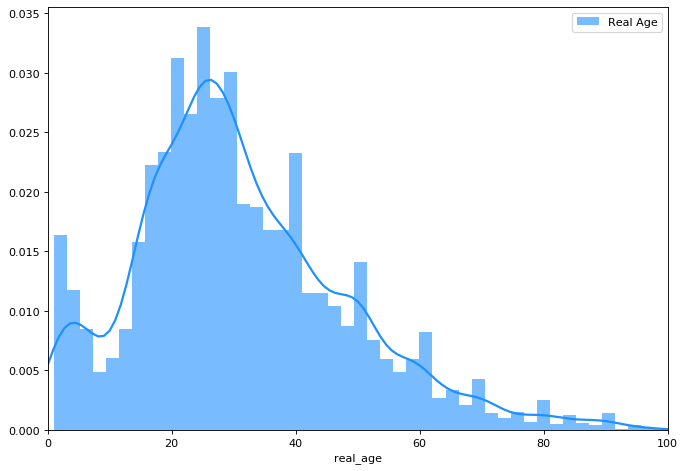

In [5]:
x1 = data['real_age']

kwargs = dict(hist_kws={'alpha':.6}, kde_kws={'linewidth':2})

plt.figure(figsize=(10,7), dpi= 80)
sns.distplot(x1, color="dodgerblue", label="Real Age", **kwargs)

plt.xlim(0,100)
plt.legend();

Из графика видно, что есть несколько пиков возраста, это от рождения до 3-5 лет, и самый большой пик - от 20 до 35 лет. 

#### Выводим на экран 10 фотографий, смотрим как устроен датасет

In [6]:
#Масштабирование изображений
train_datagen = ImageDataGenerator(
        rescale=1./255,
        horizontal_flip=True,
        vertical_flip=True,
        width_shift_range=0.2,
        height_shift_range=0.2,
        rotation_range=90)

# Создание генератор изображения 
train_gen_flow = train_datagen.flow_from_dataframe(
        dataframe=data,
        directory='/datasets/faces/final_files/',
        x_col='file_name',
        y_col='real_age',
        target_size=(224, 224),
        batch_size=32,
        class_mode='raw',
        seed=12345)

Found 7591 validated image filenames.


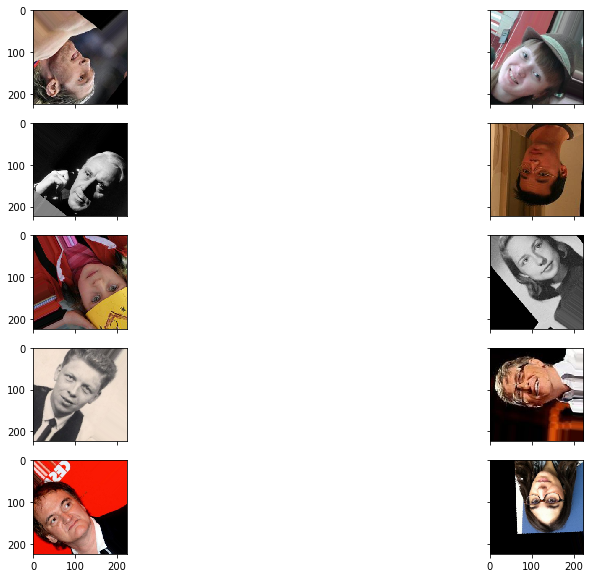

In [18]:
x,y  = train_gen_flow.next()

fig, axes = plt.subplots(ncols=2,nrows=5, sharex=True, sharey=True, figsize=(15,10))

for i, ax in enumerate(axes.flat):
    ax.imshow(x[i], interpolation='none')

plt.show()

In [8]:
x.shape

(32, 224, 224, 3)

#### Вывод
Выборка изображений. Длина выборки 7591 , размер изображений (224 х 224) и три канала.

Также мы наблюдаем разного размера изображения лиц, разный наклон, лицо занимает везде разную площадь фотографии, а также фотографии разных цветов, есть ч/б, сепия и цветные. Поворот головы также на всех фотографиях разный. 


<div class="alert alert-block alert-info">
<b>Совет: </b> Желтаельно поработать над оформление графика (название осей и самого графика, а также размер). В названиях (title) изображений можно указать возраст.
</div>

- готово

<div class="alert alert-block alert-danger">
<b>Ошибка:</b> Пожалуйста, опиши изображения: их исходный размер, поворот, цвет.
    
</div>

- готово

# 2. Обучение модели

Перенесите сюда код обучения модели и её результат вывода на экран.


(Код в этом разделе запускается в отдельном GPU-тренажёре, поэтому оформлен не как ячейка с кодом, а как код в текстовой ячейке)

In [9]:
# Функция загрузки тренировочной выборки
def load_train(path):
    data = pd.read_csv(path + 'labels.csv')
    train_datagen = ImageDataGenerator(
        validation_split=0.25,
        horizontal_flip=True,
        rescale=1./255)
    train_gen_flow = train_datagen.flow_from_dataframe(
        dataframe=data,
        directory=path + 'final_files/',
        x_col='file_name',
        y_col='real_age',
        target_size=(224, 224),
        batch_size=16,
        class_mode='raw',
        subset='training',
        seed=12345)
 
    return train_gen_flow

#Функция загрузки тестовой выборки
def load_test(path):
    data = pd.read_csv(path + 'labels.csv')
    test_datagen = ImageDataGenerator(
        validation_split=0.25,
        rescale=1./255)
    test_gen_flow = test_datagen.flow_from_dataframe(
        dataframe=data,
        directory=path + 'final_files/',
        x_col='file_name',
        y_col='real_age',
        target_size=(224, 224),
        batch_size=16,
        class_mode='raw',
        subset='validation',
        seed=12345)
 
    return test_gen_flow

In [10]:
# Функция создания модели неиросети
def create_model(input_shape):
    backbone = ResNet50(weights='imagenet',
                        input_shape=input_shape,
                        include_top=False)
 
    model = Sequential()
    model.add(backbone)
    model.add(GlobalAveragePooling2D())
    model.add(Dense(1, activation='relu'))
 
    optimizer = Adam(lr=0.0005)
    model.compile(optimizer=optimizer, loss='mse', metrics=['mae'])
 
    return model

In [11]:
# Функция обучения модели
def train_model(model, train_data, test_data, batch_size=None, epochs=20,
                steps_per_epoch=None, validation_steps=None):
 
    if steps_per_epoch is None:
        steps_per_epoch = len(train_data)
    if validation_steps is None:
        validation_steps = len(test_data)
 
    model.fit(train_data,
              validation_data=test_data,
              batch_size=batch_size, epochs=epochs,
              steps_per_epoch=steps_per_epoch,
              validation_steps=validation_steps,
              verbose=2)
 
    return model

<div class="alert alert-block alert-success">
<b>Успех:</b> Модель определена корректно. Радует, что горизонтальный флип применяется только на тренировочных данных.
</div>

#### Результат обучения модели: 

... 

<font color='blue'>
Found 5694 validated image filenames.

Found 1897 validated image filenames.

<font color='red'>
...

    
<font color='blue'>
<class 'tensorflow.python.keras.engine.sequential.Sequential'>

<font color='red'>
WARNING:tensorflow:sample_weight modes were coerced from

  ...
  
    to  
  ['...']
  
WARNING:tensorflow:sample_weight modes were coerced from

  ...
    to  
  ['...']

<font color='blue'>
Train for 356 steps, validate for 119 steps

Epoch 1/20

<font color='red'>
2020-11-09 11:38:07.220045: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcublas.so.10

2020-11-09 11:38:11.064627: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcudnn.so.7

<font color='blue'>
356/356 - 124s - loss: 202.5494 - mae: 10.7578 - val_loss: 283.7378 - val_mae: 13.2624

Epoch 2/20

356/356 - 41s - loss: 129.6577 - mae: 8.7696 - val_loss: 213.1565 - val_mae: 11.4081

Epoch 3/20

356/356 - 40s - loss: 106.5648 - mae: 7.8606 - val_loss: 133.6991 - val_mae: 8.9312

Epoch 4/20

356/356 - 41s - loss: 92.7576 - mae: 7.3525 - val_loss: 186.4692 - val_mae: 10.8815

Epoch 5/20

356/356 - 41s - loss: 76.4749 - mae: 6.6371 - val_loss: 110.2613 - val_mae: 7.8591

Epoch 6/20

356/356 - 41s - loss: 61.0552 - mae: 5.9941 - val_loss: 88.3553 - val_mae: 7.1280

Epoch 7/20

356/356 - 41s - loss: 56.6809 - mae: 5.7609 - val_loss: 156.8228 - val_mae: 9.4534

Epoch 8/20

356/356 - 41s - loss: 49.3898 - mae: 5.3747 - val_loss: 117.9614 - val_mae: 8.5068

Epoch 9/20

356/356 - 41s - loss: 40.7083 - mae: 4.9196 - val_loss: 85.6758 - val_mae: 7.0274

Epoch 10/20

356/356 - 41s - loss: 35.0426 - mae: 4.5700 - val_loss: 114.2281 - val_mae: 8.1813

Epoch 11/20

356/356 - 41s - loss: 32.4200 - mae: 4.3663 - val_loss: 100.0126 - val_mae: 7.6158

Epoch 12/20

356/356 - 40s - loss: 28.6714 - mae: 4.0962 - val_loss: 88.9138 - val_mae: 7.1437

Epoch 13/20

356/356 - 41s - loss: 26.6734 - mae: 3.9929 - val_loss: 101.1950 - val_mae: 7.9933

Epoch 14/20

356/356 - 41s - loss: 22.9632 - mae: 3.6803 - val_loss: 85.5651 - val_mae: 6.8874

Epoch 15/20

356/356 - 41s - loss: 21.4206 - mae: 3.5656 - val_loss: 81.7865 - val_mae: 6.7971

Epoch 16/20

356/356 - 41s - loss: 19.7450 - mae: 3.4322 - val_loss: 88.4832 - val_mae: 7.2627

Epoch 17/20

356/356 - 41s - loss: 18.8244 - mae: 3.3451 - val_loss: 97.3817 - val_mae: 7.7304

Epoch 18/20

356/356 - 40s - loss: 19.5700 - mae: 3.3715 - val_loss: 86.6399 - val_mae: 6.9087

Epoch 19/20

356/356 - 41s - loss: 18.2868 - mae: 3.2600 - val_loss: 87.1568 - val_mae: 7.0484

Epoch 20/20

356/356 - 41s - loss: 15.8973 - mae: 3.0508 - val_loss: 80.1679 - val_mae: 6.8776
    
<font color='red'>
WARNING:tensorflow:sample_weight modes were coerced from
  ...
    to  
  ['...']

    
<font color='blue'>

***119/119 - 10s - loss: 80.1679 - mae: 6.8776***
    
***Test MAE: 6.8776***

# 3. Анализ обученной модели

Для выполнения поставленной задачи наилучше всего справилась модель ResNet50, с одним нейроном на выходе, активацией RELU. Можно отметить, что после 20-ой эпохи обучения, mae меньше 7, что в среднем на 1 меньше, чем в поставленной задаче. 

Этот диапазон подходит для определения возрастной группы покупателей, для анализа покупок, чтобы в дальнейшем можно было предлагать товары, в которых заинтересованы покупатели этой возрастной группы. 

Не уверена, что такой большой диапазон может с точностью определить совершенолетний покупатель или нет (например 16 или 18 лет)

Анализировать покупки и предлагать товары, которые могут заинтересовать покупателей этой возрастной группы;
Тем не менее диапазон определения большой длятого чтобы определить совершенолетный ли покупетель при покупки алкоголя, но вполне подходит для того чтобы определить возрастной группы, анализировать покупки и предлагать товары, которые могут заинтересовать покупателей.

<div class="alert alert-block alert-success">
<b>Успех:</b> Анализ модели проведен отлично. Радует, что модель была описана с технической стороны и были приведены рассуждения о ее применимости со стороны бизнеса.
</div>

# Чек-лист

- [x]  Jupyter Notebook открыт
- [x]  Весь код выполняется без ошибок
- [x]  Ячейки с кодом расположены в порядке исполнения
- [x]  Исследовательский анализ данных выполнен
- [x]  Результаты исследовательского анализа данных перенесены в финальную тетрадь
- [x]  MAE модели не больше 8
- [x]  Код обучения модели скопирован в финальную тетрадь
- [x]  Результат вывода модели на экран перенесён в финальную тетрадь
- [x]  По итогам обучения модели сделаны выводы